# Week 1 Exercises — Report

**Course:** Data-Driven Methods  
**Author:** <Your Name>  
**Date:** February 05, 2026

---

## Abstract
Briefly summarize the goals, methods, and key findings (3–5 sentences).


# Exercise 1.7 — Fluid flow past a cylinder

## Problem Statement
Load the fluid‑flow‑past‑a‑cylinder dataset (each column is a snapshot reshaped into a vector). Then:

(a) Compute the SVD of the data matrix and plot the singular value spectrum and leading singular vectors. Interpret **U** as eigenflow fields and **ΣV\*** as time‑varying amplitudes.

(b) Reconstruct the movie for various truncation values **r**. Find the **r** needed to capture 90%, 99%, and 99.9% of the flow energy (Frobenius‑norm squared). Plot reconstructed movies for these **r** values, compare fidelity, and compute the squared Frobenius error \|X − X̂\|_F^2.

(c) Fix **r = 10** and compute the truncated SVD. Define **W = Σ_r V_r\***. Interpret each column **w_k** as the mixture of the first 10 eigenflows for snapshot **k**. Verify by comparing snapshot **k** of **X** with **U_r w_k**.

(d) Build a linear regression model for time evolution of amplitudes:

w_{k+1} = A w_k.

Form **W** with columns 1..m−1 of ΣV\* and **W'** with columns 2..m. Compute **A** using the pseudo‑inverse of **W** (via SVD). Compute eigenvalues of **A** and plot them in the complex plane.

(e) Use **A** to advance the state: w_k = A^{k−1} w_1. Reconstruct the flow fields from predicted amplitudes and compare with the true snapshots.

## Approach / Method
Describe dataset source, preprocessing, SVD details, truncation/energy calculation, reconstruction, and regression setup for **A**. Note any numerical choices.

## Results
Include plots of singular values, leading modes, reconstructed snapshots/movies, energy‑capture table, error norms, and eigenvalue plot.


In [32]:
import numpy as np
from scipy.io import loadmat

# (a) Load data and compute SVD
import matplotlib.pyplot as plt

# Load the dataset
data = loadmat('../DATA/FLUIDS/CYLINDER_ALL.mat')
X = data['VORTALL'] 

# Compute SVD
U, s, Vt = np.linalg.svd(X, full_matrices=False) # Could not run for the full matrix because of memory constraints, so set full_matrices to False

print(f"Data shape: {X.shape}")
print(f"U shape: {U.shape}, s shape: {s.shape}, Vt shape: {Vt.shape}")

Data shape: (89351, 151)
U shape: (89351, 151), s shape: (151,), Vt shape: (151, 151)


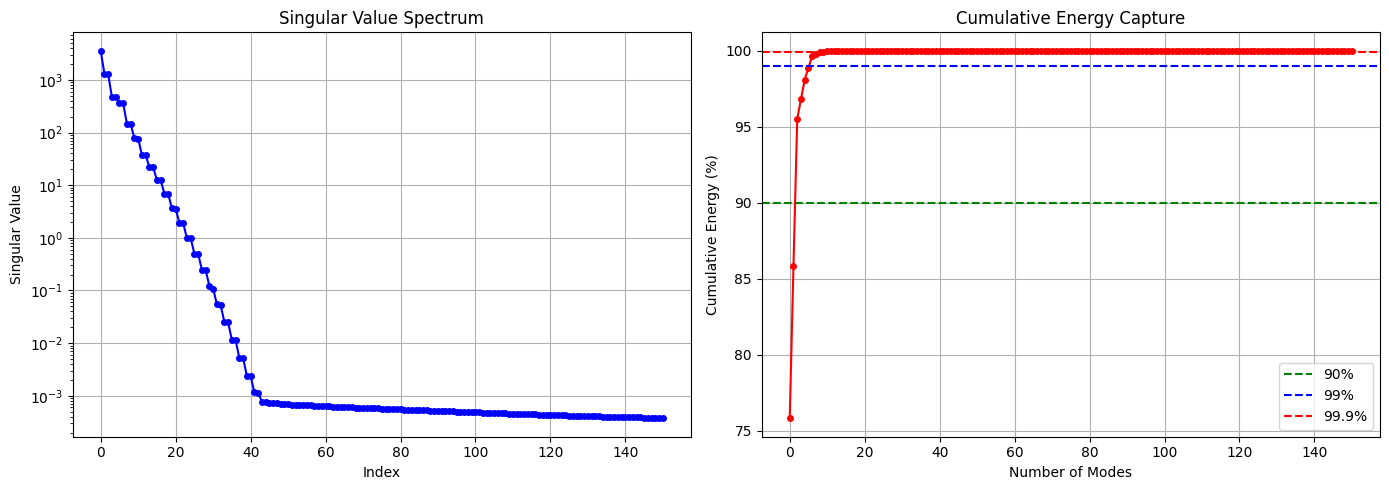

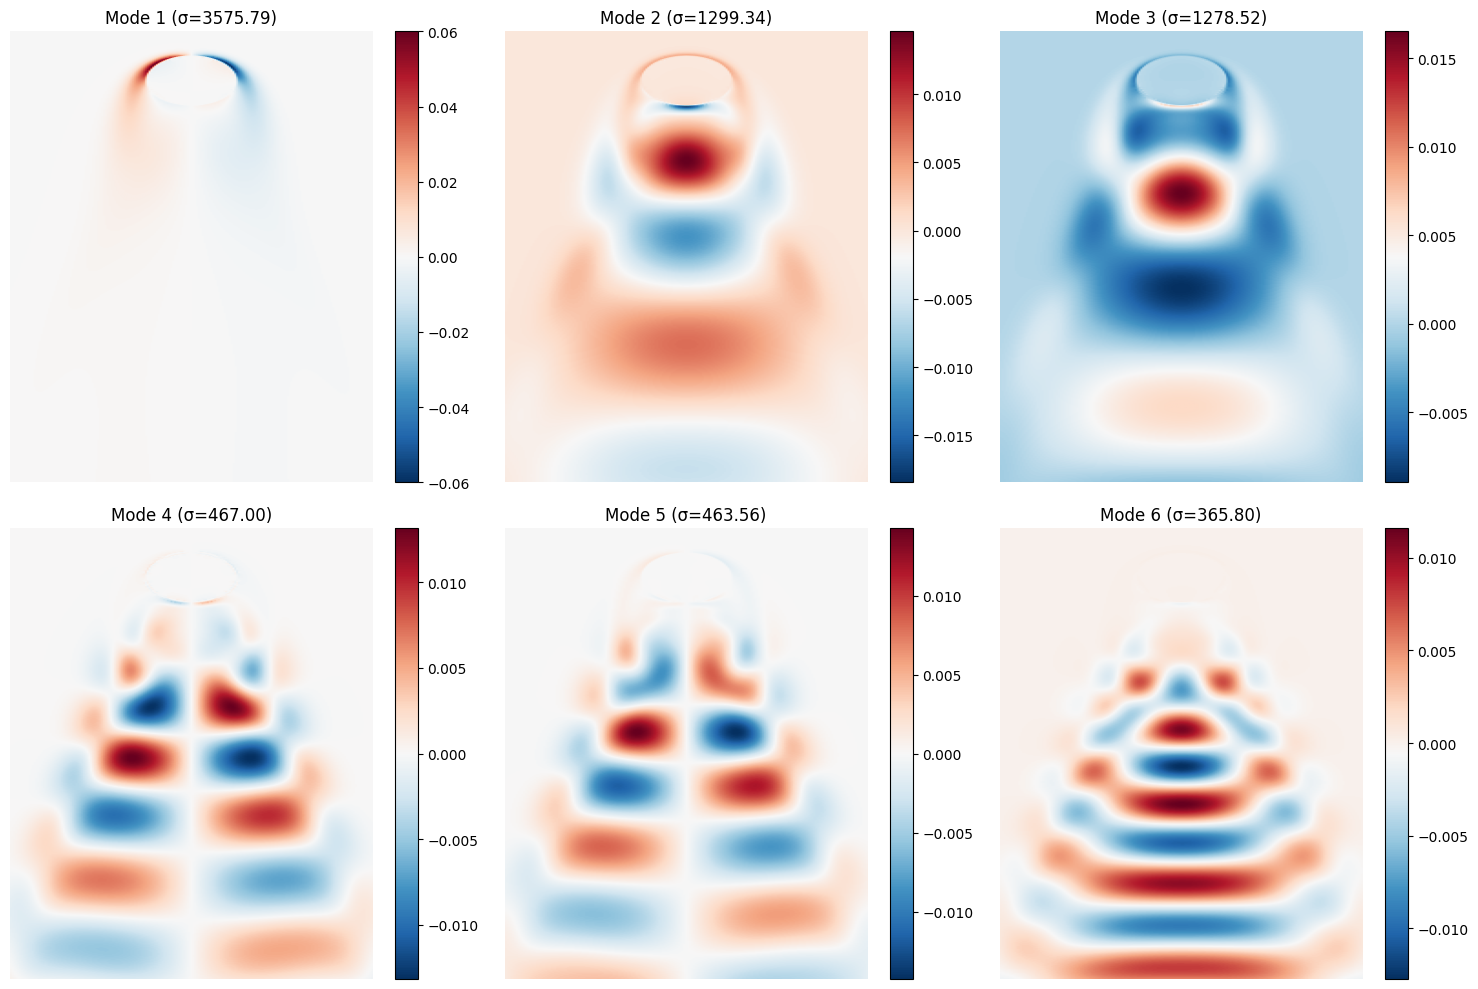

In [33]:
# TODO: plot singular value spectrum and leading modes
# Plot singular value spectrum
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Singular value spectrum
axes[0].semilogy(s, 'bo-', markersize=4)
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Singular Value')
axes[0].set_title('Singular Value Spectrum')
axes[0].grid(True)

# Cumulative energy
cumulative_energy = np.cumsum(s**2) / np.sum(s**2) * 100
axes[1].plot(cumulative_energy, 'ro-', markersize=4)
axes[1].set_xlabel('Number of Modes')
axes[1].set_ylabel('Cumulative Energy (%)')
axes[1].set_title('Cumulative Energy Capture')
axes[1].grid(True)
axes[1].axhline(y=90, color='g', linestyle='--', label='90%')
axes[1].axhline(y=99, color='b', linestyle='--', label='99%')
axes[1].axhline(y=99.9, color='r', linestyle='--', label='99.9%')
axes[1].legend()

plt.tight_layout()
plt.show()

# Plot leading singular vectors (eigenflow fields)
# Reshape spatial modes for visualization
nx, ny = data['nx'][0, 0], data['ny'][0, 0]
num_modes = 6

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(num_modes):
    ax = axes[i // 3, i % 3]
    mode_field = U[:, i].reshape(ny, nx)
    im = ax.imshow(mode_field, cmap='RdBu_r', aspect='auto')
    ax.set_title(f'Mode {i+1} (σ={s[i]:.2f})')
    ax.axis('off')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


In [34]:
# (b) Truncation, energy capture, reconstructions, and errors


In [35]:
# TODO: compute energy capture and r for 90/99/99.9%
total_energy = np.sum(s**2)
energy_capture = np.cumsum(s**2) / total_energy * 100

r_values = [np.argmax(energy_capture >= 90) + 1, 
            np.argmax(energy_capture >= 99) + 1, 
            np.argmax(energy_capture >= 99.9) + 1]
print(f"Selected r values for 90%, 99%, 99.9% energy capture: {r_values}")

# TODO: reconstruct X_hat for selected r values
X_hat_90 = U[:, :r_values[0]] @ np.diag(s[:r_values[0]]) @ Vt[:r_values[0], :]
X_hat_99 = U[:, :r_values[1]] @ np.diag(s[:r_values[1]]) @ Vt[:r_values[1], :]
X_hat_999 = U[:, :r_values[2]] @ np.diag(s[:r_values[2]]) @ Vt[:r_values[2], :]

# TODO: compute ||X - X_hat||_F^2
error_90 = np.linalg.norm(X - X_hat_90, 'fro')**2
error_99 = np.linalg.norm(X - X_hat_99, 'fro')**2
error_999 = np.linalg.norm(X - X_hat_999, 'fro')**2

print(f"Reconstruction error for 90% energy capture: {error_90}")
print(f"Reconstruction error for 99% energy capture: {error_99}")
print(f"Reconstruction error for 99.9% energy capture: {error_999}")

Selected r values for 90%, 99%, 99.9% energy capture: [np.int64(3), np.int64(7), np.int64(9)]
Reconstruction error for 90% energy capture: 753357.9772952134
Reconstruction error for 99% energy capture: 58421.904997206344
Reconstruction error for 99.9% energy capture: 16045.668777409444


In [36]:
from matplotlib.animation import FuncAnimation, PillowWriter

# TODO: plot reconstructed snapshots/movies for selected r

for label, X_hat, r in zip(['90% (r=3)', '99% (r=7)', '99.9% (r=9)'], 
                            [X_hat_90, X_hat_99, X_hat_999], r_values):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    def update(frame):
        ax.clear()
        snapshot = X_hat[:, frame].reshape(ny, nx)
        im = ax.imshow(snapshot, cmap='RdBu_r', aspect='auto')
        ax.set_title(f'{label} - Snapshot {frame+1}')
        ax.axis('off')
        return [im]
    
    anim = FuncAnimation(fig, update, frames=X_hat.shape[1], blit=True)
    writer = PillowWriter(fps=15)
    anim.save(f'outputs/reconstruction_{label.replace(" ", "_").replace("(", "").replace(")", "")}.gif', writer=writer)
    plt.close(fig)


In [37]:
# (c) r = 10 truncated SVD and snapshot verification


In [38]:
# (c) r = 10 truncated SVD and snapshot verification
r = 10
W = np.diag(s[:r]) @ Vt[:r, :]

# Verify X[:, k] ≈ U_r @ w_k for selected snapshots
k_values = [0, 50, 100, 150]
verification_results = []

for k in k_values:
    X_k_actual = X[:, k]
    X_k_approx = U[:, :r] @ W[:, k]
    error = np.linalg.norm(X_k_actual - X_k_approx, 2)
    relative_error = error / np.linalg.norm(X_k_actual, 2)
    verification_results.append((k, error, relative_error))
    print(f"Snapshot k={k:3d}: ||X[:, k] - U_r @ w_k||_2 = {error:.4e}, relative error = {relative_error:.4e}")


print("\nVerification Summary:")
print(f"{'Snapshot k':>10s} {'Error':>15s} {'Rel. Error':>15s}")
for k, err, rel_err in verification_results:
    print(f"{k:10d} {err:15.4e} {rel_err:15.4e}")

Snapshot k=  0: ||X[:, k] - U_r @ w_k||_2 = 6.3103e+00, relative error = 1.8842e-02
Snapshot k= 50: ||X[:, k] - U_r @ w_k||_2 = 9.1682e+00, relative error = 2.7242e-02
Snapshot k=100: ||X[:, k] - U_r @ w_k||_2 = 7.4826e+00, relative error = 2.2570e-02
Snapshot k=150: ||X[:, k] - U_r @ w_k||_2 = 8.3821e+00, relative error = 2.5087e-02

Verification Summary:
Snapshot k           Error      Rel. Error
         0      6.3103e+00      1.8842e-02
        50      9.1682e+00      2.7242e-02
       100      7.4826e+00      2.2570e-02
       150      8.3821e+00      2.5087e-02


In [39]:
# (d) Linear regression for amplitude dynamics


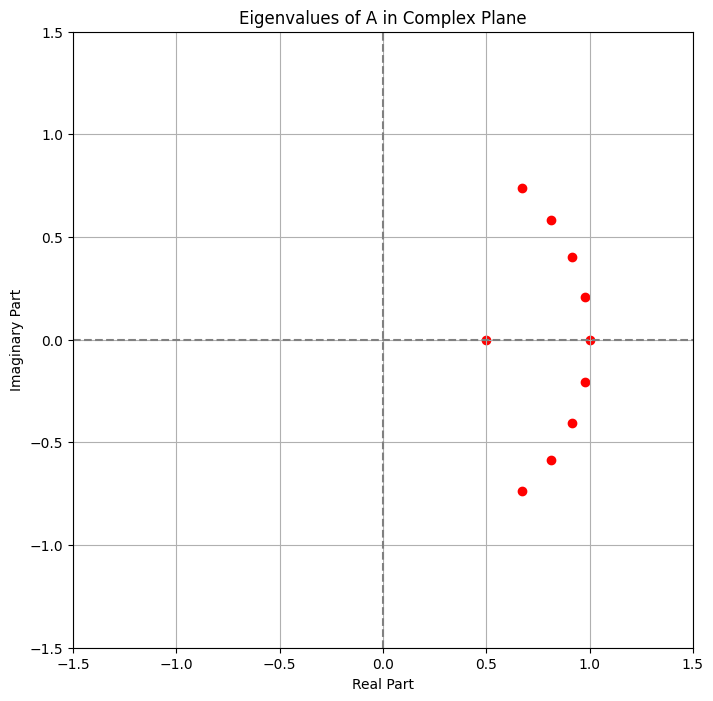

In [40]:
# TODO: build W and W' and compute A via pseudo-inverse
W_prime = W[:, 1:]
W_curr = W[:, :-1]
# TODO: Compute the SVD of W and use this to compute the pseudo-inverse of
# W to solve for A. and plot in complex plane
U_w, s_w, Vt_w = np.linalg.svd(W_curr, full_matrices=False)
s_w_inv = np.zeros_like(s_w)
for i in range(len(s_w)):
    if s_w[i] > 1e-10:  # Avoid division by zero
        s_w_inv[i] = 1 / s_w[i]
W_pseudo_inv = Vt_w.T @ np.diag(s_w_inv) @ U_w.T
A = W_prime @ W_pseudo_inv

# Plot eigenvalues of A in complex plane
eigenvalues = np.linalg.eigvals(A)
plt.figure(figsize=(8, 8))
plt.scatter(eigenvalues.real, eigenvalues.imag, color='red', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Eigenvalues of A in Complex Plane')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

In [41]:
# (e) Predict amplitudes with A and compare reconstructions


In [42]:
# Create videos showing amplitude differences for each reconstruction percentage
for idx, (r_val, label) in enumerate(zip(r_values, ['90%', '99%', '99.9%'])):
    # True amplitudes for this r
    W_true = np.diag(s[:r_val]) @ Vt[:r_val, :]
    
    # Predicted amplitudes for this r
    W_pred_r = np.zeros((r_val, W_true.shape[1]))
    W_pred_r[:, 0] = W_true[:, 0]  # Start with true initial condition
    
    for k in range(1, W_pred_r.shape[1]):
        A_r = A[:r_val, :r_val]
        W_pred_r[:, k] = A_r @ W_pred_r[:, k-1]
    
    # Reconstruct flow fields
    X_true_r = U[:, :r_val] @ W_true
    X_pred_r = U[:, :r_val] @ W_pred_r
    
    # Compute difference
    X_diff_r = X_true_r - X_pred_r
    
    # Create animation
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(np.zeros((ny, nx)), cmap='RdBu_r', aspect='auto')
    cbar = plt.colorbar(im, ax=ax)
    
    def update(frame):
        ax.clear()
        diff_field = X_diff_r[:, frame].reshape(ny, nx)
        im = ax.imshow(diff_field, cmap='RdBu_r', aspect='auto')
        ax.set_title(f'{label} - Difference (k={frame})')
        ax.axis('off')
        return [im]
    
    anim = FuncAnimation(fig, update, frames=X_true_r.shape[1], blit=True)
    writer = PillowWriter(fps=15)
    anim.save(f'outputs/difference_{label.replace("%", "")}.gif', writer=writer)
    plt.close(fig)


# Exercise X01.1 — Physics‑informed least‑squares for disease spread

## Problem Statement
Set up a physics‑informed least‑squares regression to determine parameters of a disease‑spread model. Reproduce the example from the previous slide, then apply to a new virus model with synthetic data.

## Approach / Method
Describe the chosen model (e.g., SIR/SEIR/variants), how data are generated, the regression formulation, and the optimization method.

## Results
Provide estimated parameters, confidence/uncertainty if applicable, and plots comparing model vs. data.


In [43]:
# TODO: define model equations


In [44]:
# TODO: generate synthetic data


In [45]:
# TODO: set up least-squares regression


In [46]:
# TODO: fit model and evaluate


In [47]:
# TODO: plots and metrics


## Discussion
Discuss parameter identifiability, fit quality, sensitivity to noise, and comparison with reference example.


# Exercise X01.2 — Physics‑informed least‑squares for PDE parameter (Re)

## Problem Statement
Set up a physics‑informed least‑squares regression to estimate a PDE parameter (e.g., Reynolds number) for flow past a cylinder. Reproduce results from Nielsen et al. (2025).

## Approach / Method
Describe the PDE (e.g., vorticity equation), data/fields used, regression formulation, and numerical details.

## Results
Report estimated Reynolds number and compare with reference values. Provide plots/tables.


In [48]:
# TODO: define PDE and residuals


In [49]:
# TODO: load or generate flow data


In [50]:
# TODO: set up least-squares regression


In [51]:
# TODO: fit and validate


In [52]:
# TODO: plots and metrics


## Discussion
Discuss estimation accuracy, numerical sensitivity, and alignment with Nielsen et al. (2025).


# Conclusion
Summarize the main findings and outline next steps.
